In [1]:
## IMPLEMENTATION OF DEEP QLEARNING BASED ON: https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import os, sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import traci

import tqdm
from tqdm import tqdm

# import environment
import custom_env

# DEBUG variable
DEBUG = 0

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
env = custom_env.CustomEnv()
steps = env.MAX_STEPS

n_actions = len(env.ACTIONS)
n_observations = env.NUM_STATES_FINAL

batch_size = 32
gamma = 0.9
epsilon_start = 1.0
epsilon_end = 0.0
epsilon_decay = 0.99
capacity = 100000
num_episodes = env.MAX_EPISODES
epsilon_episodes = 1000

env.MAX_EPISODES

20000

In [ ]:
class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size,action_size, seed, fc1_unit = 128,
                 fc2_unit = 128):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_size)
        
    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.9             # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns form environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        ## compute and minimize the loss
        criterion = torch.nn.MSELoss()
        # Local model is one which we need to train so it's in training mode
        self.qnetwork_local.train()
        # Target model is one with which we need to get our target so it's in evaluation mode
        # So that when we do a forward pass with target model it does not calculate gradient.
        # We will update target model weights with soft_update function
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim)
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
    
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))
        
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
agent = Agent(state_size=2,action_size=6,seed=0)

# stats about the training
TargetVehicleStatistics = np.zeros((math.floor(num_episodes/10), 2))
rewards_taken = np.zeros(num_episodes)

In [ ]:
def get_state(vehicle_id):
    speed = traci.vehicle.getSpeed(vehicle_id)
    distance_to_front = env.get_distance_from_leader(vehicle_id)
    
    if (speed <= -1073741820) :
        return 0, 0 # car was teleported, so there is a crash
    elif (distance_to_front < 0):
        return 0, 1 # car was teleported, so there is a crash
    else:
        n_speed = math.floor(speed)
        n_distance_to_front = math.floor(distance_to_front)
        return [(n_speed,n_distance_to_front)], -1
    
def take_action(action, previous_state, target_car):
    if (action == 1):
        #traci.vehicle.setAccel(target_car, 1)
        traci.vehicle.setAcceleration(target_car, 1, traci.simulation.getDeltaT())
    elif (action == 3):
        traci.vehicle.setAcceleration(target_car, -1, traci.simulation.getDeltaT())
    elif (action == 2):
        traci.vehicle.setAcceleration(target_car, 3, traci.simulation.getDeltaT())
    elif (action == 4):
        traci.vehicle.setAcceleration(target_car, -3, traci.simulation.getDeltaT())
    elif (action == 5):
        traci.vehicle.setAcceleration(target_car, -7, traci.simulation.getDeltaT())
    else:
        traci.vehicle.setAcceleration(target_car, 0, traci.simulation.getDeltaT())
        
    # Advance the simulation by one step
    traci.simulationStep()
    
    # Get the resulting state
    state, check_state = get_state(target_car)

    if (check_state >= 0):
        reward = env.COLLISION_REWARD
        if DEBUG:
            print("By this: " + str(check_state))
        return previous_state, reward, True, "collision"
    else:
        # Calculate the reward
        reward = env.getRewardFINAL(action, target_car)
        #print("Reward obtained: "+ str(reward))

        # Check if the episode has ended
        done, done_reason = check_done(target_car)
        return state, reward, done, done_reason
    
def check_done(vehicle_id):
    # Returns True if the episode has ended, False otherwise.
    # Check for collision
    collisonList = traci.simulation.getCollidingVehiclesIDList()
    if len(collisonList) > 0:
        if vehicle_id in collisonList:
            return True, "collision"
    if traci.vehicle.getLanePosition(vehicle_id) < 0:  # DELETE THIS
        return True, "outoflane"
    return False, "none"
    
# function for stats
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

100%|██████████| 7000/7000 [1:02:42<00:00,  1.86it/s]


################# Training simulation has ended #################


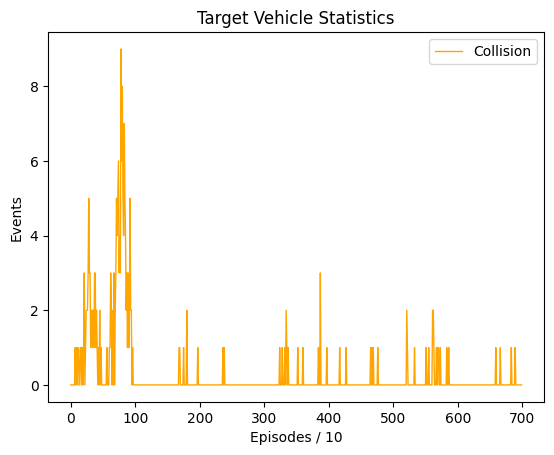

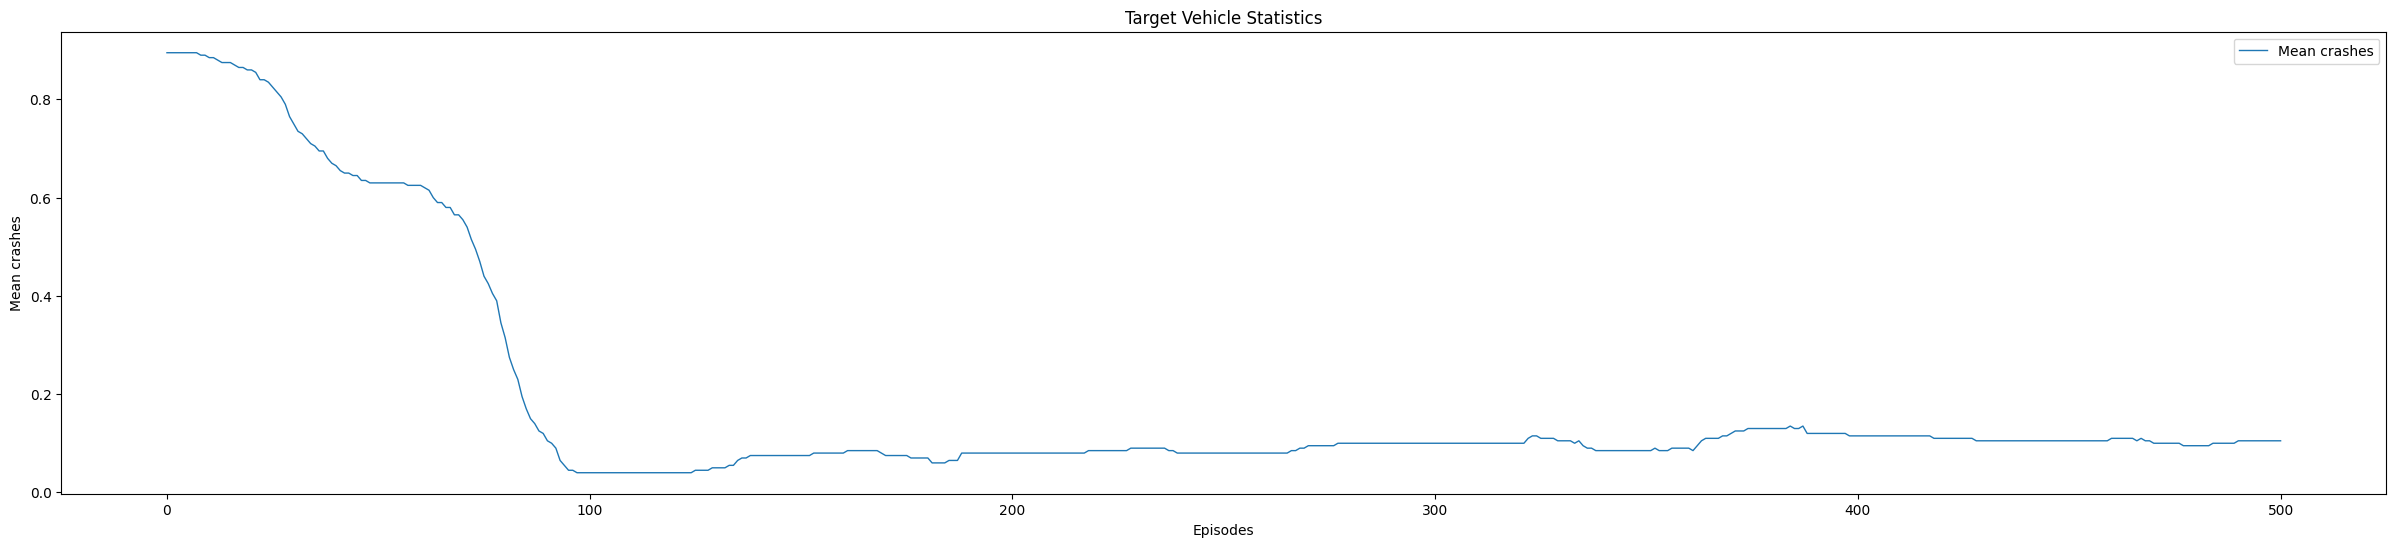

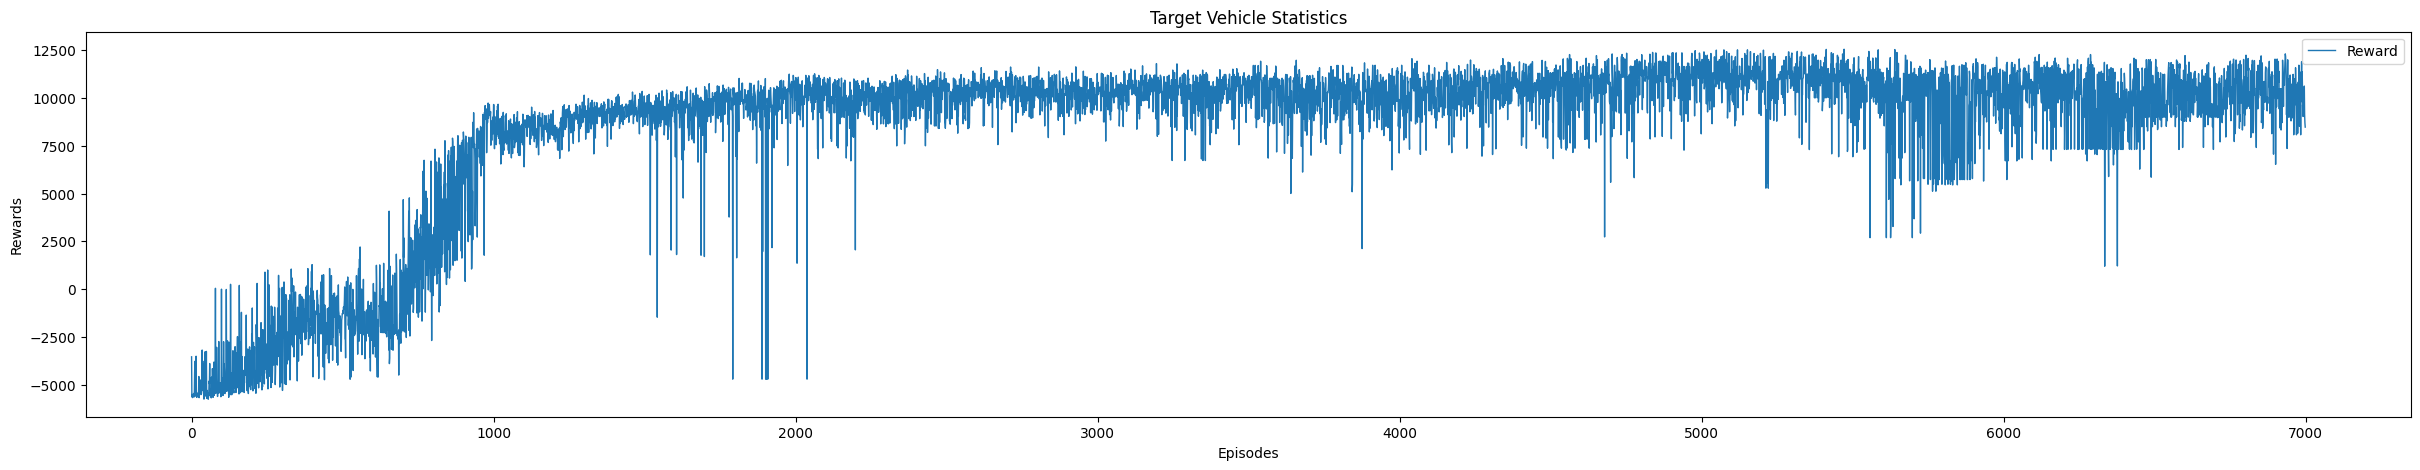

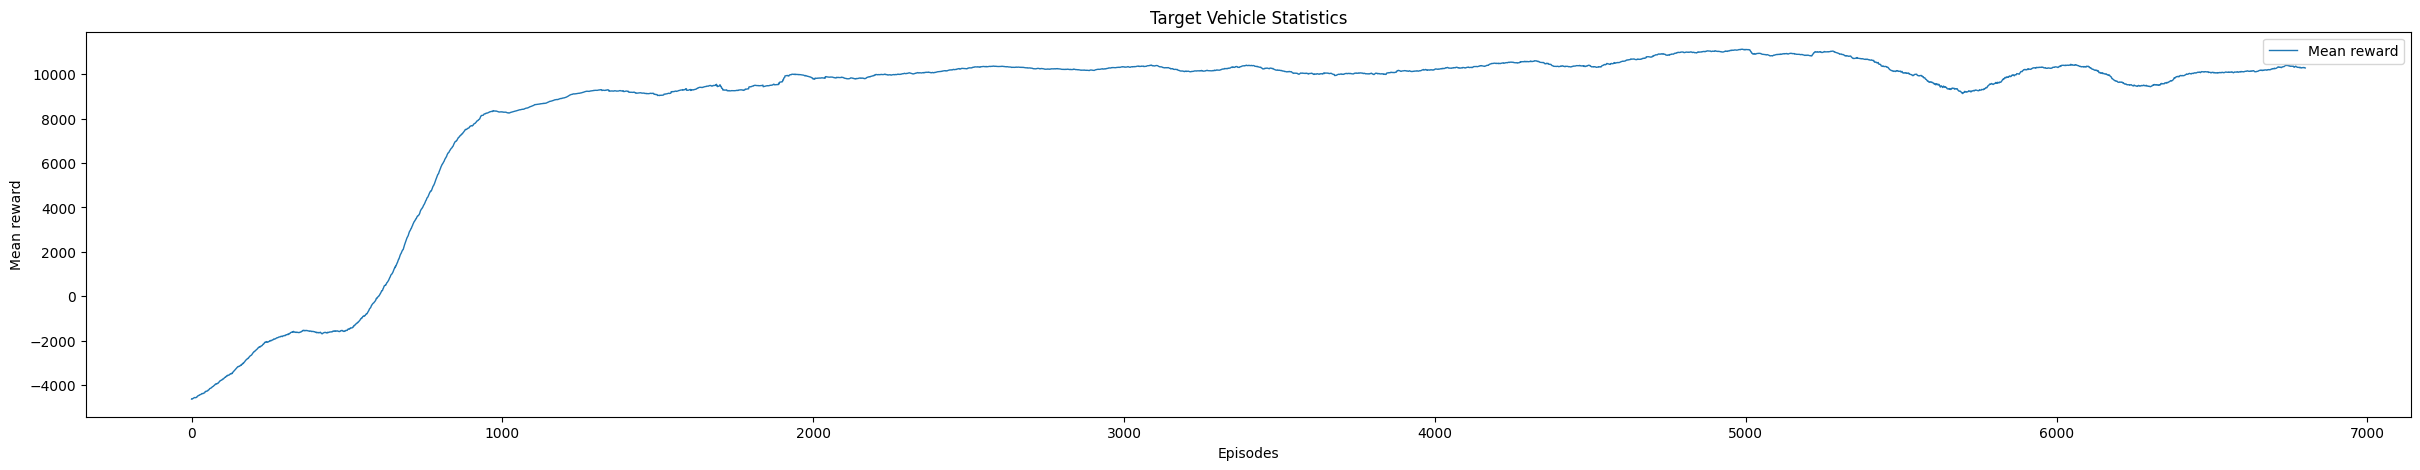

In [ ]:
# start SUMO
runGUI = False
sumoBinary = "sumo"
if runGUI:
    sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
    
traci.start([sumoBinary, "-c", "./data/demo.sumocfg", "--no-step-log", '-W'])
target_vehicle = "car_12" # our car

scores = [] # list containing score from each episode
scores_window = deque(maxlen=100) # last 100 scores

# Set the initial epsilon value
epsilon = epsilon_start

for episode in tqdm(range(num_episodes)):
    
    total_reward = 0
    episodeIndex = math.floor(episode/10)
    
    traci.load(["-c", "./data/demo.sumocfg", "--no-step-log", '-W'])
    
    # 8 steps for initialization and then dqn controls the car
    traci.simulationStep()
    traci.simulationStep()
    traci.simulationStep()
    traci.simulationStep()
    traci.simulationStep()
    traci.simulationStep()
    traci.simulationStep()
    traci.simulationStep()
    traci.vehicle.setSpeedMode(vehID=target_vehicle, sm=0)
    traci.vehicle.setSpeed(target_vehicle,random.randint(0,20)) # for starting
    traci.vehicle.setColor(target_vehicle,(255,0,0))
    
    # initial state
    state, _ = get_state(target_vehicle)
    state = np.array(state)
    
    score = 0
    for step in range(steps):
        action = agent.act(state,epsilon)
        next_state, reward, done, done_reason = take_action(action, state, target_vehicle)
        
        next_state = np.array(next_state)
        total_reward += reward
        
        agent.step(state,action,reward,next_state,done)
        
        state = next_state
        score += reward
        if done:
            break
        scores_window.append(score) ## save the most recent score
        scores.append(score)
        total_reward += reward
        
    rewards_taken[episode] = total_reward
    epsilon = max(epsilon - 1 / epsilon_episodes,0)
    if done_reason == "teleport":
            TargetVehicleStatistics[episodeIndex, 0] += 1
    elif done_reason == "collision":
        if DEBUG:
            print("Crash, :" + str(step))
        TargetVehicleStatistics[episodeIndex, 1] += 1
      
        
traci.close()
        
print("################# Training simulation has ended #################")
x_axis = list(range(0, math.floor(num_episodes / 10)))
plt.plot(x_axis, TargetVehicleStatistics[:, 1], label="Collision", linewidth = 1, color="orange")
plt.xlabel('Episodes / 10')
plt.ylabel('Events')
plt.title('Target Vehicle Statistics')
plt.legend()
plt.rcParams["figure.figsize"] = (30,6)
plt.show()

mean_crashes = running_mean(TargetVehicleStatistics[:, 1],env.MAX_STEPS)
#x_axis = list(range(0, episodes))
plt.plot(mean_crashes, label="Mean crashes", linewidth = 1)
plt.xlabel('Episodes')
plt.ylabel('Mean crashes')
plt.title('Target Vehicle Statistics')
plt.legend()
plt.rcParams["figure.figsize"] = (30,5)
plt.show()

x_axis = list(range(0, num_episodes))
plt.plot(x_axis, rewards_taken, label="Reward", linewidth = 1)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Target Vehicle Statistics')
plt.legend()
plt.rcParams["figure.figsize"] = (30,5)
plt.show()

mean_rewards = running_mean(rewards_taken,env.MAX_STEPS)
#x_axis = list(range(0, episodes))
plt.plot(mean_rewards, label="Mean reward", linewidth = 1)
plt.xlabel('Episodes')
plt.ylabel('Mean reward')
plt.title('Target Vehicle Statistics')
plt.legend()
plt.rcParams["figure.figsize"] = (30,5)
plt.show()    

In [9]:
# TEST SIMULATION with the QTable obtained
runGUI = True
sumoBinary = "sumo"
if runGUI:
    sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
    
traci.start([sumoBinary, "-c", "./data/demo.sumocfg", "--no-step-log", '-W'])
target_vehicle = "car_12"

# Set the initial epsilon value
epsilon = 0
    
total_reward = 0
episodeIndex = math.floor(episode/10)

traci.load(["-c", "./data/demo.sumocfg", "--no-step-log", '-W'])

# 3 steps for initialization and then dqn controls the car
traci.simulationStep()
traci.simulationStep()
traci.simulationStep()
traci.simulationStep()
traci.simulationStep()
traci.simulationStep()
traci.simulationStep()
traci.simulationStep()
traci.vehicle.setSpeedMode(vehID=target_vehicle, sm=0)
traci.vehicle.setColor(target_vehicle,(255,0,0))

# initial state
state, _ = get_state(target_vehicle)
state = np.array(state)

score = 0
for step in range(steps):
    action = agent.act(state,epsilon)
    next_state, reward, done, done_reason = take_action(action, state, target_vehicle)
    
    next_state = np.array(next_state)
    total_reward += reward
    
    agent.step(state,action,reward,next_state,done)
    
    state = next_state
    score += reward
    if done:
        break

traci.close()